In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import skew

# Set plot style
plt.style.use('ggplot')

In [3]:
# Load the dataset
try:
    df = pd.read_csv('D:\internship\customer_segmentation\data\customer_transactions_mock_data.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'customer_transactions_mock_data.csv' not found. Please ensure the file is in the correct directory.")
    exit()

Data loaded successfully.


In [4]:
# Display basic information and head to understand the structure
print("\n--- Initial Data Info ---")
df.info()
print("\n--- First 5 Rows ---")
print(df.head())



--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15143 entries, 0 to 15142
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    15143 non-null  object 
 1   CustomerID       15143 non-null  object 
 2   TransactionDate  15143 non-null  object 
 3   ProductID        15143 non-null  object 
 4   Quantity         15143 non-null  int64  
 5   UnitPrice        15143 non-null  float64
 6   TotalPrice       15143 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 828.3+ KB

--- First 5 Rows ---
  TransactionID CustomerID TransactionDate ProductID  Quantity  UnitPrice  \
0    TRX50000_0   CUST1302      2022-01-12  Prod_107         3      53.74   
1    TRX50000_1   CUST1302      2022-01-12  Prod_104         2      43.15   
2    TRX50000_2   CUST1302      2022-01-12  Prod_107         1      59.80   
3    TRX50001_0   CUST1267      2023-10-17  Prod_108     

In [5]:
# Convert 'TransactionDate' to datetime objects
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

In [6]:
# Check for missing values
print("\n--- Missing Values Check ---")
print(df.isnull().sum())


--- Missing Values Check ---
TransactionID      0
CustomerID         0
TransactionDate    0
ProductID          0
Quantity           0
UnitPrice          0
TotalPrice         0
dtype: int64


In [7]:
# Handle missing CustomerID if any by dropping them (customers without ID can't be segmented)
df.dropna(subset=['CustomerID'], inplace=True)

# --- RFM Analysis --- #

In [8]:
# Determine a snapshot date (one day after the latest transaction date in the dataset)
snapshot_date = df['TransactionDate'].max() + pd.Timedelta(days=1)
print(f"\nSnapshot Date for RFM analysis: {snapshot_date.date()}")


Snapshot Date for RFM analysis: 2023-12-31


In [9]:
df.head()

,TransactionID,CustomerID,TransactionDate,ProductID,Quantity,UnitPrice,TotalPrice
0,TRX50000_0,CUST1302,2022-01-12,Prod_107,3,53.74,161.22
1,TRX50000_1,CUST1302,2022-01-12,Prod_104,2,43.15,86.30
2,TRX50000_2,CUST1302,2022-01-12,Prod_107,1,59.80,59.80
3,TRX50001_0,CUST1267,2023-10-17,Prod_108,1,214.31,214.31
4,TRX50001_1,CUST1267,2023-10-17,Prod_109,3,312.02,936.06


In [10]:
# Calculate RFM values
rfm_df = df.groupby('CustomerID').agg(
    Recency=('TransactionDate', lambda date: (snapshot_date - date.max()).days),
    Frequency=('TransactionDate', 'count'), # Count of transactions for each customer
    Monetary=('TotalPrice', 'sum') # Sum of purchase amounts for each customer
).reset_index()

# Display RFM DataFrame head
print("\n--- RFM DataFrame Head ---")
print(rfm_df.head())



--- RFM DataFrame Head ---
  CustomerID  Recency  Frequency  Monetary
0   CUST1000        9         41   6855.79
1   CUST1001       49         10   2856.43
2   CUST1002        7         25   2175.73
3   CUST1003       22         33   1085.57
4   CUST1004      134         27   6887.81


# --- Exploratory Data Analysis of RFM Values --- #

In [11]:
print("\n--- RFM Statistics ---")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].describe())



--- RFM Statistics ---
          Recency   Frequency    Monetary
count  500.000000  500.000000    500.0000
mean    71.310000   30.286000   6279.1636
std     65.035075   10.224543   4430.0027
min      1.000000    4.000000    377.0000
25%     22.000000   23.000000   2579.4425
50%     54.000000   30.000000   5292.9750
75%    105.250000   37.000000   9319.3500
max    500.000000   57.000000  20453.5000


In [12]:
# Check for skewness
print("\n--- Skewness of RFM Features ---")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].skew())


--- Skewness of RFM Features ---
Recency      1.647826
Frequency    0.207320
Monetary     0.790106
dtype: float64


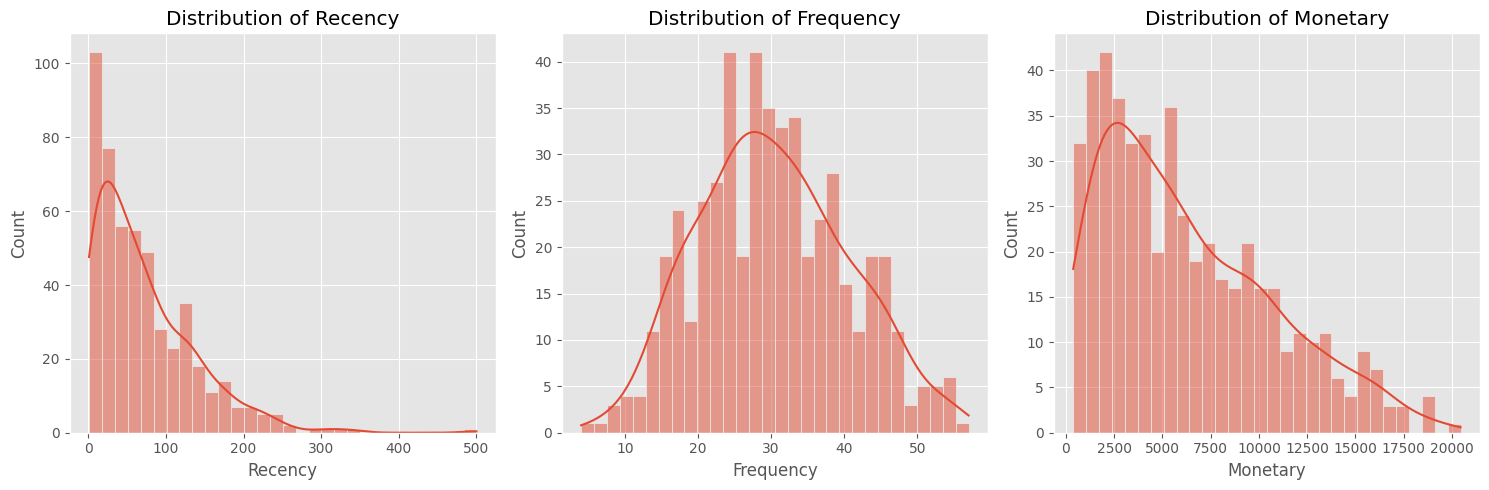

In [13]:
# Visualize the distributions before transformation
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], bins=30, kde=True)
plt.title('Distribution of Recency')
plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], bins=30, kde=True)
plt.title('Distribution of Frequency')
plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], bins=30, kde=True)
plt.title('Distribution of Monetary')
plt.tight_layout()

In [14]:
# Apply log transformation (using log1p to handle zeros, if any, and reduce skewness)
rfm_log_transformed = rfm_df.copy()
for col in ['Recency', 'Frequency', 'Monetary']:
    # Add a small constant or ensure values are non-negative for log transformation if needed.
    # Recency usually starts from 0, Frequency/Monetary can be 0 for some customer, but usually not in this context.
    # np.log1p(x) computes log(1+x), which is good for values starting from 0.
    rfm_log_transformed[col] = np.log1p(rfm_log_transformed[col])

print("\n--- Skewness of Log-Transformed RFM Features ---")
print(rfm_log_transformed[['Recency', 'Frequency', 'Monetary']].skew())



--- Skewness of Log-Transformed RFM Features ---
Recency     -0.693848
Frequency   -0.805187
Monetary    -0.579559
dtype: float64


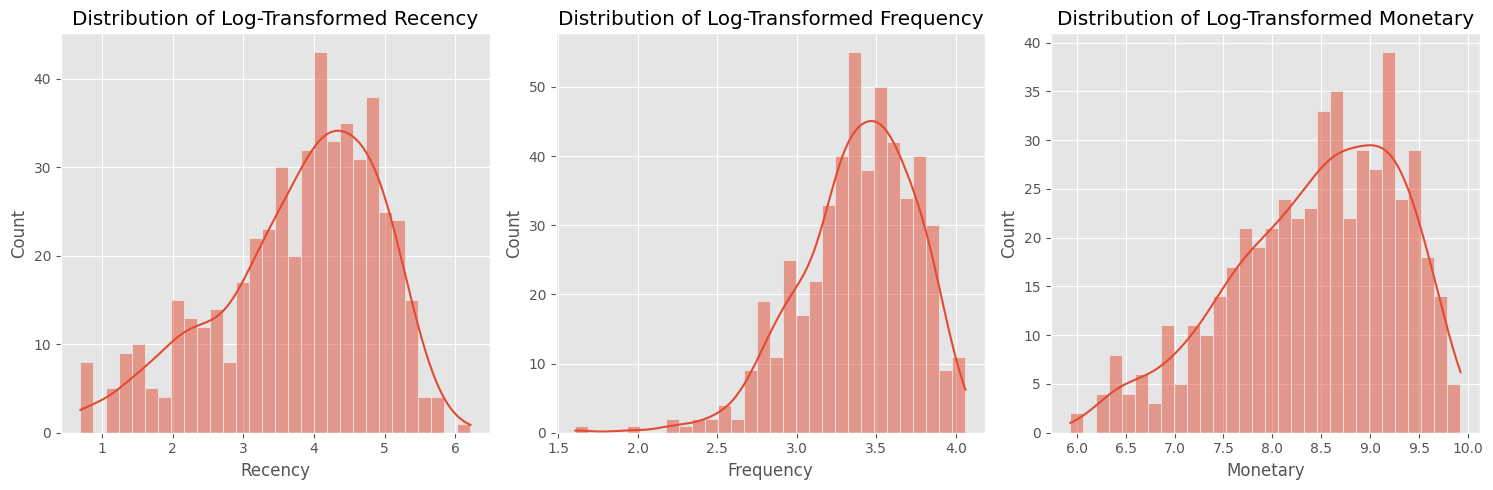

In [15]:
# Visualize the distributions after transformation
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm_log_transformed['Recency'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Recency')
plt.subplot(1, 3, 2)
sns.histplot(rfm_log_transformed['Frequency'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Frequency')
plt.subplot(1, 3, 3)
sns.histplot(rfm_log_transformed['Monetary'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Monetary')
plt.tight_layout()


In [16]:
# --- Feature Scaling ---
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log_transformed[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency_Scaled', 'Frequency_Scaled', 'Monetary_Scaled'])
rfm_scaled_df['CustomerID'] = rfm_df['CustomerID'] # Keep CustomerID for merging later
print("\n--- Scaled RFM Data Head ---")
print(rfm_scaled_df.head())


--- Scaled RFM Data Head ---
   Recency_Scaled  Frequency_Scaled  Monetary_Scaled CustomerID
0       -1.311601          0.980667         0.458701   CUST1000
1        0.107585         -2.729292        -0.562686   CUST1001
2       -1.508367         -0.347315        -0.880192   CUST1002
3       -0.577150          0.395533        -1.690935   CUST1003
4        0.983425         -0.142103         0.464138   CUST1004


In [17]:
# --- Clustering (K-Means) ---

# Determine optimal number of clusters using Elbow Method
wcss = []
k_range = range(1, 11) # Test k from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init for robustness
    kmeans.fit(rfm_scaled_df[['Recency_Scaled', 'Frequency_Scaled', 'Monetary_Scaled']])
    wcss.append(kmeans.inertia_)

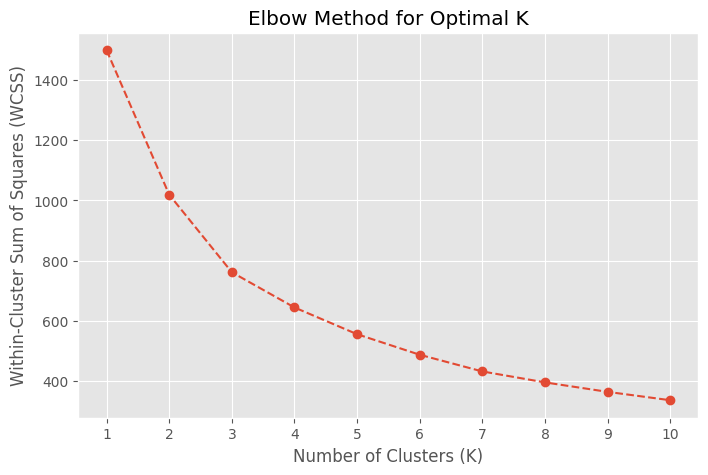

In [18]:
# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.grid(True)


### Based on the elbow plot, visually choose an optimal k. Let's assume k=3 or k=4 is a good starting point.
### For demonstration, let's proceed with k=4. User can adjust based on their specific elbow plot.


In [19]:
# Apply K-Means clustering with the chosen optimal_k
optimal_k = 4 # This should be chosen based on the elbow plot generated.
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled_df[['Recency_Scaled', 'Frequency_Scaled', 'Monetary_Scaled']])


In [20]:
# --- Segment Profiling and Interpretation ---
print(f"\n--- Segment Profiling (K={optimal_k}) ---")
segment_profiles = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().sort_values(by='Recency', ascending=True)
print(segment_profiles)

# Sort the clusters by Recency to give intuitive names
# The cluster with lowest Recency (most recent purchases) is generally the "best"
# The cluster with highest Recency (least recent purchases) is generally the "worst"

# Example of giving meaningful names (this part requires manual interpretation)
# Based on the example output of segment_profiles, we'd name them.
# For instance, if cluster 0 has high R,F,M, it's 'Champions'. If cluster 3 has low R,F,M it's 'Lost'.
# This is a generic interpretation, and the exact names depend on the actual means.


--- Segment Profiling (K=4) ---
            Recency  Frequency     Monetary
Cluster                                    
2          8.021053  31.294737  6638.691579
0         71.281250  29.750000  1768.448437
1         79.347418  35.957746  9347.917371
3        116.135417  17.239583  3625.298438


In [21]:
# Let's map cluster IDs to more descriptive names based on typical RFM segment patterns
# This is a placeholder and will need to be adapted based on the actual `segment_profiles` output.
# Sort by Recency (ascending), then Frequency (descending), then Monetary (descending) to get a consistent order for naming
segment_profiles_sorted = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()
segment_profiles_sorted = segment_profiles_sorted.sort_values(by=['Recency', 'Frequency', 'Monetary'], ascending=[True, False, False])


In [22]:
# Define segment names based on sorted profiles (this is an example mapping)
# You need to manually inspect the `segment_profiles` output and assign names meaningfully.
# This logic assumes that lower Recency is better, higher Frequency and Monetary are better.
# Let's try to infer names by sorting and then iterating.

segment_names_map = {}
if optimal_k == 4:
    # Example for k=4, based on typical RFM interpretations. Adjust based on your data's output.
    # The actual order and characteristics will depend on the KMeans output.
    # The following is a common heuristic for mapping:
    # Cluster with lowest Recency, highest F & M = Champions
    # Cluster with low Recency, good F & M = Loyal
    # Cluster with high Recency, low F & M = Lost
    # Cluster with medium Recency, F & M = At-Risk / Needs Attention
    # Sort based on Recency (asc), Frequency (desc), Monetary (desc) to get a general 'best' to 'worst' order
    # (or reverse, depending on how you want to rank and name)
    sorted_clusters = segment_profiles.sort_values(by=['Recency', 'Monetary', 'Frequency'], ascending=[True, False, False])



In [30]:
# Assign names based on this sorted order (example)
cluster_mapping = {}
if len(sorted_clusters) >= 4:
        # Assuming 4 clusters
    cluster_mapping[sorted_clusters.index[0]] = 'Champions (Best Customers)' # Lowest Recency, Highest F/M
    cluster_mapping[sorted_clusters.index[1]] = 'Loyal Customers' # Good Recency, F/M
    cluster_mapping[sorted_clusters.index[2]] = 'At-Risk Customers' # Moderate Recency, F/M
    cluster_mapping[sorted_clusters.index[3]] = 'Lost Customers' # Highest Recency, Lowest F/M
elif len(sorted_clusters) == 3:
    cluster_mapping[sorted_clusters.index[0]] = 'Champions (Best Customers)'
    cluster_mapping[sorted_clusters.index[1]] = 'At-Risk Customers'
    cluster_mapping[sorted_clusters.index[2]] = 'Lost Customers'
elif len(sorted_clusters) == 2:
    cluster_mapping[sorted_clusters.index[0]] = 'High-Value Segment'
    cluster_mapping[sorted_clusters.index[1]] = 'Low-Value Segment'
else:
    print(f"Warning: Only {len(sorted_clusters)} clusters found. Cannot assign standard names.")

# Map the cluster names to the RFM DataFrame
rfm_df['Segment'] = rfm_df['Cluster'].map(cluster_mapping)
# Display the final RFM DataFrame with segments
print("\n--- Final RFM DataFrame with Segments ---")
print(rfm_df[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Segment']].head())
# Save the RFM DataFrame with segments to a new CSV file
rfm_df.to_csv('customer_segments.csv', index=False)


   


--- Final RFM DataFrame with Segments ---
  CustomerID  Recency  Frequency  Monetary  Cluster  \
0   CUST1000        9         41   6855.79        2   
1   CUST1001       49         10   2856.43        3   
2   CUST1002        7         25   2175.73        2   
3   CUST1003       22         33   1085.57        0   
4   CUST1004      134         27   6887.81        1   

                      Segment  
0  Champions (Best Customers)  
1              Lost Customers  
2  Champions (Best Customers)  
3             Loyal Customers  
4           At-Risk Customers  


In [32]:
rfm_df['Segment_Name'] = rfm_df['Cluster'].map(cluster_mapping)
print("\n--- Segment Distribution ---")
print(rfm_df['Segment_Name'].value_counts())


--- Segment Distribution ---
Segment_Name
At-Risk Customers             213
Lost Customers                 96
Loyal Customers                96
Champions (Best Customers)     95
Name: count, dtype: int64


In [31]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,Cluster,Segment_Name,Segment
0,CUST1000,9,41,6855.79,2,Champions (Best Customers),Champions (Best Customers)
1,CUST1001,49,10,2856.43,3,Lost Customers,Lost Customers
2,CUST1002,7,25,2175.73,2,Champions (Best Customers),Champions (Best Customers)
3,CUST1003,22,33,1085.57,0,Loyal Customers,Loyal Customers
4,CUST1004,134,27,6887.81,1,At-Risk Customers,At-Risk Customers


In [33]:
# Final segment profiles with names
final_segment_profiles = rfm_df.groupby('Segment_Name')[['Recency', 'Frequency', 'Monetary']].mean()
print("\n--- Final Segment Profiles (Mean RFM Values) ---")
print(final_segment_profiles.sort_values(by='Recency', ascending=True))



--- Final Segment Profiles (Mean RFM Values) ---
                               Recency  Frequency     Monetary
Segment_Name                                                  
Champions (Best Customers)    8.021053  31.294737  6638.691579
Loyal Customers              71.281250  29.750000  1768.448437
At-Risk Customers            79.347418  35.957746  9347.917371
Lost Customers              116.135417  17.239583  3625.298438


In [27]:
# Example: using a flag to control whether to name segments automatically
assign_names = True  # Set to False if you don’t want to assign names automatically

if assign_names:
    # Save with segment names
    rfm_df.to_csv('customer_rfm_segments.csv', index=False)
    print("\nCustomer RFM segments saved to 'customer_rfm_segments.csv'")
else:
    print(f"\nProceeding without automatic segment naming for {optimal_k} clusters. Please manually inspect and name them.")
    rfm_df.to_csv('customer_rfm_clusters.csv', index=False)
    print("\nCustomer RFM clusters saved to 'customer_rfm_clusters.csv'")



Customer RFM segments saved to 'customer_rfm_segments.csv'
